# Ideas

- build an ensemble of models from different folds

- different encoder type + different encoder backbone (MAnet, Linknet, FPN, PSPNet, PAN)

- different feature extractor type (LSTM, PANN, SpecFeatureExtractor)
- different decoder type (MLP, LSTM)
- different optimizer (Lion, Adam, SGD)
- offset 25, 30 for your best model

- use stacking with ensemble

- DETR2DCNN
- gaussian loss
- different mixup / cutmix ratio
- gradient_clip_val
- different seed (just for fun)
- select best weights for each train and average them (EMA)

In [4]:
import pandas as pd
from pathlib import Path
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra
from src.utils.metrics import event_detection_ap

from src.utils.post_process import post_process_for_seg
import jupyter_black
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import optuna


jupyter_black.load()
plt.style.use("ggplot")

EXP_NAME = "transformer_dur_8640_sigma_12_mirror"
RUN_NAME = "single"
RESULT_DIR = Path("../output/train") / EXP_NAME / RUN_NAME
TYPE = "_score"  # '_score'


def load_config(result_dir: Path):
    # clear previous initialization
    GlobalHydra.instance().clear()

    # initialize hydra
    config_path = result_dir / ".hydra"
    initialize(config_path=config_path.as_posix())
    # load the config
    cfg = compose(config_name="config")

    return cfg


cfg = load_config(RESULT_DIR)
preds = np.load(RESULT_DIR / f"preds{TYPE}.npy")
labels = np.load(RESULT_DIR / f"labels{TYPE}.npy")
keys = np.load(RESULT_DIR / "keys.npy")

gt_df = pd.read_csv(Path(cfg.dir.data_dir) / "train_events.csv")
gt_df = gt_df[gt_df["series_id"].isin(cfg.split.valid_series_ids)].dropna().reset_index(drop=True)

/tmp/ipykernel_1059048/1761037087.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path=config_path.as_posix())


# Optimize postprocess parameters using Optuna

In [5]:
import torch
from scipy.signal import find_peaks
from scipy import signal
from sklearn.metrics import mean_squared_error

device = "cuda" if torch.cuda.is_available() else "cpu"


# def post_process_for_seg(
#     keys: list[str], preds: np.ndarray, score_th: float = 0.01, distance: int = 5000
# ) -> pl.DataFrame:
#     """make submission dataframe for segmentation task

#     Args:
#         keys (list[str]): list of keys. key is "{series_id}_{chunk_id}"
#         preds (np.ndarray): (num_series * num_chunks, duration, 2)
#         score_th (float, optional): threshold for score. Defaults to 0.5.

#     Returns:
#         pl.DataFrame: submission dataframe
#     """
#     series_ids = np.array(list(map(lambda x: x.split("_")[0], keys)))
#     unique_series_ids = np.unique(series_ids)

#     records = []
#     for series_id in unique_series_ids:
#         series_idx = np.where(series_ids == series_id)[0]
#         this_series_preds = preds[series_idx].reshape(-1, 2)

#         for i, event_name in enumerate(["onset", "wakeup"]):
#             this_event_preds = this_series_preds[:, i]

#             onset_candi = torch.Tensor(this_event_preds).to(device)
#             window_maxima = torch.nn.functional.max_pool1d_with_indices(
#                 onset_candi.view(1, -1), distance, 1, padding=distance // 2
#             )[1].squeeze()
#             candidates = window_maxima.unique()
#             steps = (
#                 candidates[(window_maxima[candidates] == candidates).nonzero()]
#                 .squeeze(1)
#                 .cpu()
#                 .numpy()
#             )
#             scores = this_event_preds[steps]

#             for step, score in zip(steps, scores):
#                 if score < score_th:
#                     continue

#                 records.append(
#                     {
#                         "series_id": series_id,
#                         "step": step,
#                         "event": event_name,
#                         "score": score,
#                     }
#                 )

#     if len(records) == 0:  # If there is no prediction, insert dummy
#         records.append(
#             {
#                 "series_id": series_id,
#                 "step": 0,
#                 "event": "onset",
#                 "score": 0,
#             }
#         )

#     sub_df = pl.DataFrame(records).sort(by=["series_id", "step"])
#     row_ids = pl.Series(name="row_id", values=np.arange(len(sub_df)))
#     sub_df = sub_df.with_columns(row_ids).select(["row_id", "series_id", "step", "event", "score"])
#     return sub_df


pred_df: pl.DataFrame = post_process_for_seg(keys, preds, score_th=0.0001, distance=90)

pred_df = pred_df.to_pandas()
score = event_detection_ap(gt_df, pred_df)

score, len(pred_df)

(0.7635746461996556, 41908)

In [6]:
# (0.7690624613584934, 48173)

In [82]:
def objective(trial: optuna.Trial):
    # score_th = 0.005
    score_th = trial.suggest_float("score_th", 0, 0.5)
    distance = trial.suggest_int("distance", 30, 400)

    pred_df: pl.DataFrame = post_process_for_seg(keys, preds, score_th=score_th, distance=distance)
    score = event_detection_ap(gt_df, pred_df.to_pandas())

    return score


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print(study.best_params)

[I 2023-11-18 22:20:54,263] A new study created in memory with name: no-name-dfbb6302-cffc-4db7-b9b5-6a2555af3dc0
[I 2023-11-18 22:20:57,270] Trial 0 finished with value: 0.7313637232160094 and parameters: {'score_th': 0.08574914047113069, 'distance': 177}. Best is trial 0 with value: 0.7313637232160094.
[I 2023-11-18 22:21:00,470] Trial 1 finished with value: 0.7134276752396983 and parameters: {'score_th': 0.19279201963069015, 'distance': 58}. Best is trial 0 with value: 0.7313637232160094.
[I 2023-11-18 22:21:04,116] Trial 2 finished with value: 0.7177355118287021 and parameters: {'score_th': 0.17294051685899714, 'distance': 39}. Best is trial 0 with value: 0.7313637232160094.
[I 2023-11-18 22:21:06,836] Trial 3 finished with value: 0.7092463538908435 and parameters: {'score_th': 0.18734327099431097, 'distance': 248}. Best is trial 0 with value: 0.7313637232160094.
[I 2023-11-18 22:21:09,505] Trial 4 finished with value: 0.7022476178822656 and parameters: {'score_th': 0.2244785233642

{'score_th': 0.0005079074664883215, 'distance': 61}


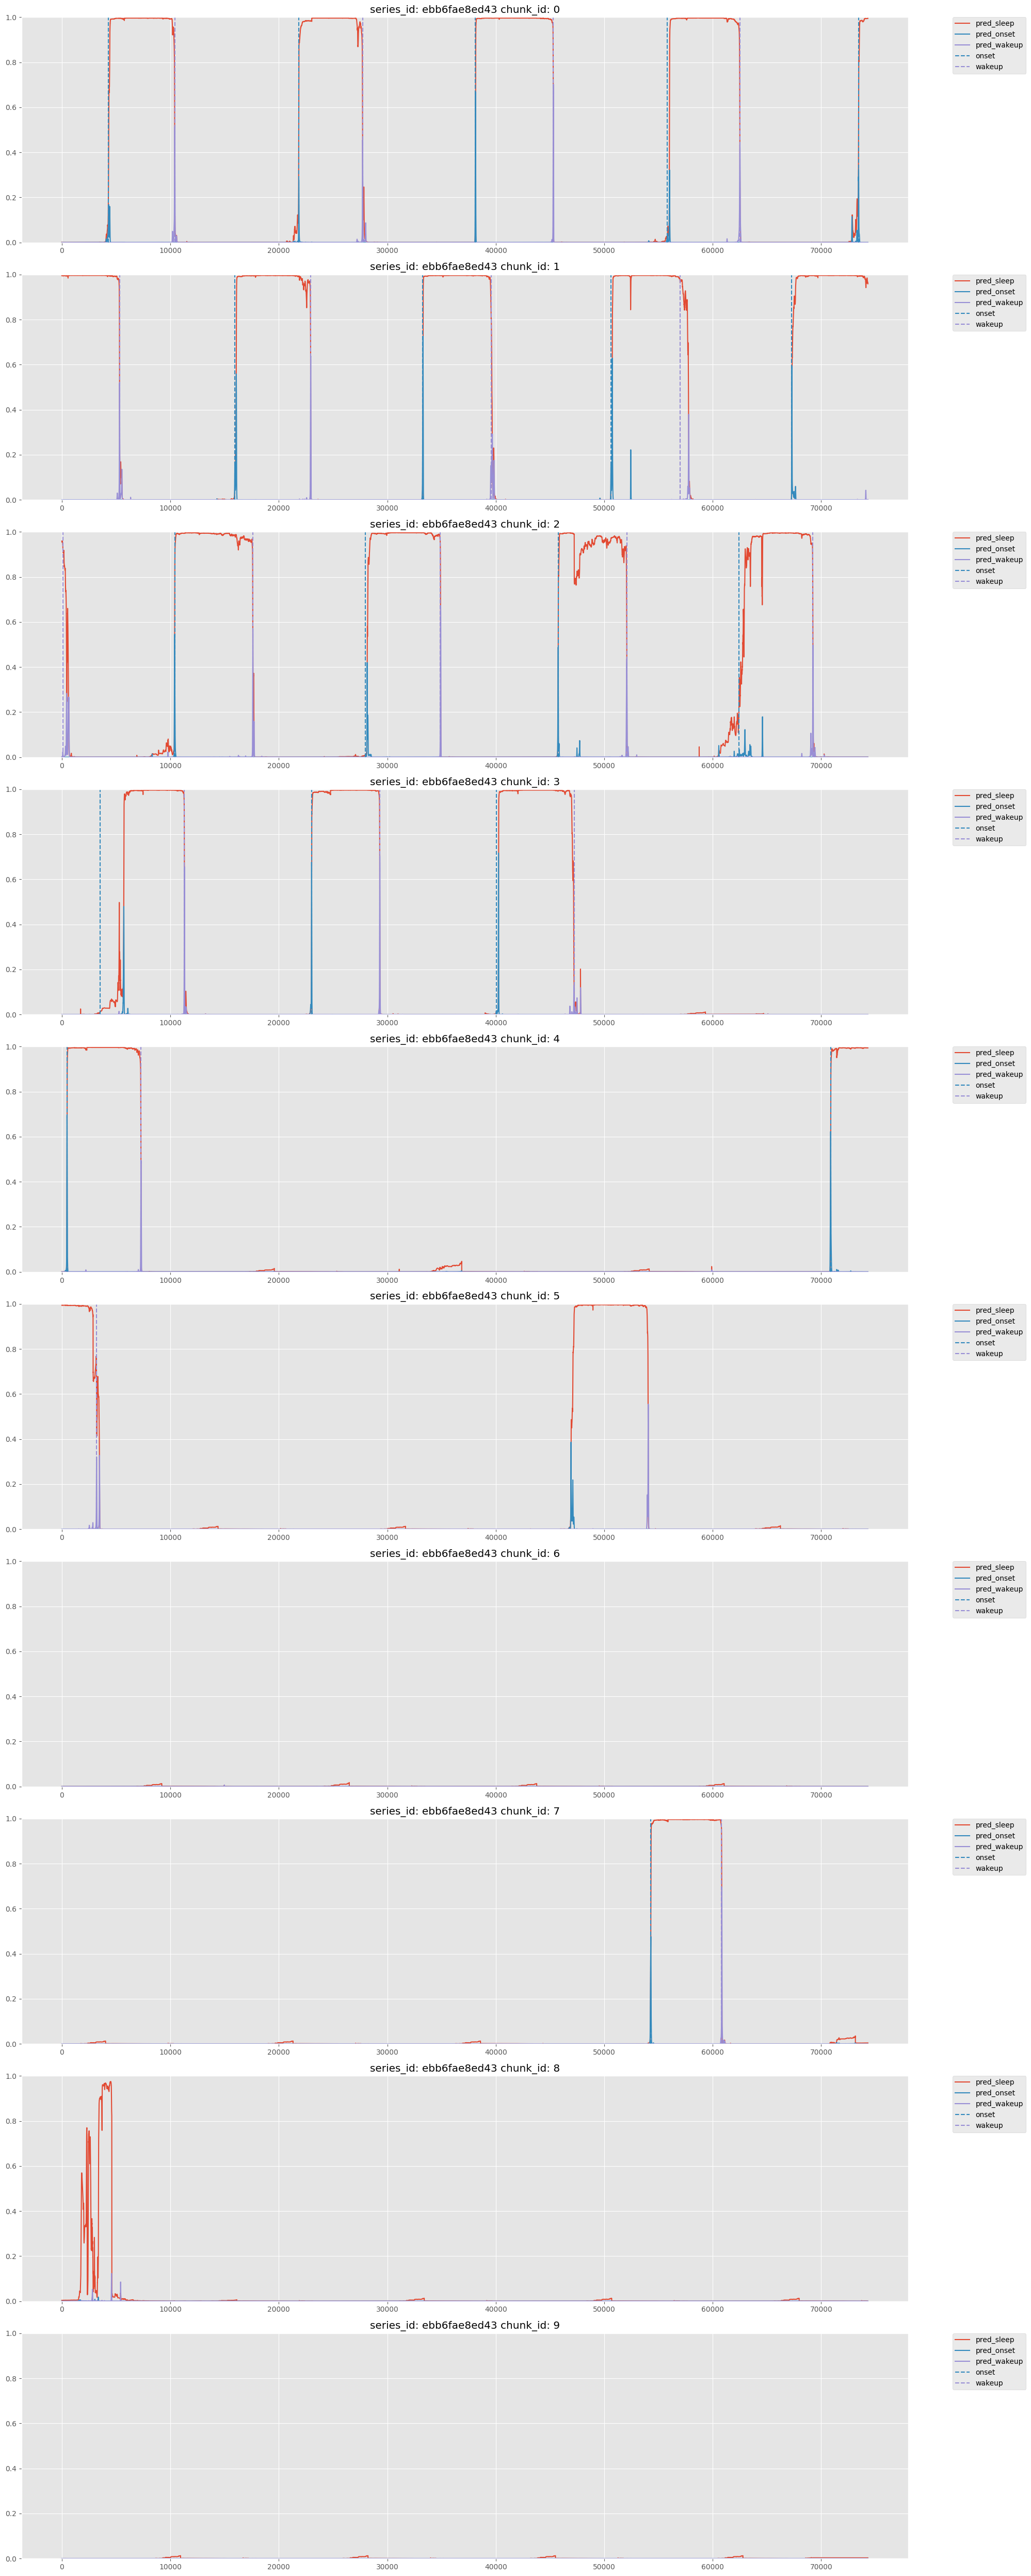

In [15]:
def plot_random_sample(gt_df, keys, preds, labels, num_samples=1, num_chunks=10):
    # get series ids
    series_ids = np.array(list(map(lambda x: x.split("_")[0], keys)))
    unique_series_ids = np.unique(series_ids)

    # get random series
    random_series_ids = np.random.choice(unique_series_ids, num_samples)

    for i, random_series_id in enumerate(random_series_ids):
        # get random series
        series_idx = np.where(series_ids == random_series_id)[0]
        this_series_preds = preds[series_idx].reshape(-1, 3)
        this_series_labels = labels[series_idx].reshape(-1, 3)

        # split series
        this_series_preds = np.split(this_series_preds, num_chunks)
        this_series_labels = np.split(this_series_labels, num_chunks)
        this_series_len = [0] + [len(x) for x in this_series_labels]
        this_series_len = np.cumsum(this_series_len)

        gt_df = gt_df[gt_df["series_id"] == random_series_id]

        fig, axs = plt.subplots(num_chunks, 1, figsize=(20, 5 * num_chunks))

        if num_chunks == 1:
            axs = [axs]

        for j in range(num_chunks):
            this_series_preds_chunk = this_series_preds[j]
            this_series_labels_chunk = this_series_labels[j]

            # get onset and wakeup idx
            gt_tmp = gt_df[
                (gt_df["step"] >= this_series_len[j]) & (gt_df["step"] <= this_series_len[j + 1])
            ]
            onset_idx = gt_tmp.loc[gt_tmp["event"] == "onset", "step"].to_list()
            onset_idx = onset_idx - this_series_len[j]
            wakeup_idx = gt_tmp.loc[gt_tmp["event"] == "wakeup", "step"].to_list()
            wakeup_idx = wakeup_idx - this_series_len[j]

            axs[j].plot(this_series_preds_chunk[:, 0], label="pred_sleep")
            axs[j].plot(this_series_preds_chunk[:, 1], label="pred_onset")
            axs[j].plot(this_series_preds_chunk[:, 2], label="pred_wakeup")
            axs[j].vlines(onset_idx, 0, 1, label="onset", linestyles="dashed", color="C1")
            axs[j].vlines(wakeup_idx, 0, 1, label="wakeup", linestyles="dashed", color="C2")
            axs[j].set_ylim(0, 1)
            axs[j].set_title(f"series_id: {random_series_id} chunk_id: {j}")
            axs[j].legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)

    plt.tight_layout()


plot_random_sample(gt_df, keys, preds, labels, num_chunks=10)